In [75]:
import os

from google.colab import drive
drive.mount('/content/gdrive')

os.chdir('/content/gdrive/MyDrive/first_try_of_fastai')

print("------------------------------------------------------------------")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
------------------------------------------------------------------


In [76]:
#export
import os
os.chdir('/content/gdrive/MyDrive/first_try_of_fastai/exp')
from nb_08 import *
os.chdir('/content/gdrive/MyDrive/first_try_of_fastai')

In [77]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)

In [79]:
import PIL,os,mimetypes
Path.ls = lambda x: list(x.iterdir())

image_extensions = set(k for k,v in mimetypes.types_map.items() if v.startswith('image/') )

def setify(o): return o if isinstance(o,set) else set(listify(o))

def _get_files(p, fs, extensions=None):
  p = Path(p)
  res = [p/f for f in fs if not f.startswith('.')
          and ((not extensions) or f'.{f.split(".")[-1].lower()}' in  extensions)]
  return res

def get_files(path, extensions=None, recurse=False, include=None):
  path = Path(path)
  extensions = setify(extensions)
  extensions = {e.lower() for e in extensions}
  if recurse:
    res = []
    for p,d,f in os.walk(path):
      if include is not None: d[:] = [o for o in d if o in include]
      else:                   d[:] = [o for o in d if not o.startswith('.')]
      res += _get_files(p,f,extensions)
    return res
  else:
    f = [o.name for o in os.scandir(path) if o.is_file()]
    return _get_files(path, f, extensions)

def compose(x, funcs, *args, order_key="_order", **kwargs):
  key = lambda o: getattr(o, order_key, 0)
  for f in sorted(listify(funcs), key=key): x = f(x, **kwargs)
  return x

class ItemList(ListContainer):
  def __init__(self, items, path='.', tfms=None):
    super().__init__(items)
    self.path, self.tfms = Path(path), tfms

  def __repr__(self): return f'{super().__repr__()}\nPath: {self.path}'
  def new(self, items): return self.__class__(items, self.path, tfms = self.tfms)

  def get(self, i): return i
  def _get(self, i): return compose(self.get(i), self.tfms)

  def __getitem__(self, idx):
    res = super().__getitem__(idx)
    if isinstance(res, list): return [self._get(o) for o in res]
    return self._get(res)

class ImageList(ItemList):
  @classmethod
  def from_files(cls, path, extensions = None, recurse=True, include=None, **kwargs):
    if extensions is None: extensions = image_extensions
    return cls(get_files(path, extensions, recurse=recurse, include = include), path, **kwargs)

  def get(self, fn): return PIL.Image.open(fn)

class Transform(): _order=0

class MakeRGB(Transform):
  def __call__(self, item): return item.convert('RGB')

def make_rgb(item): return item.convert('RGB')

def grandparent_splitter(fn, valid_name = 'valid', train_name="train"):
  gp = fn.parent.parent.name
  return True if gp==valid_name else False if gp==train_name else None

def split_by_func(ds, f):
  items = ds.items
  mask = [f(o) for o in items]

  train = [o for o,m in zip(items, mask) if m==False]
  valid = [o for o,m in zip(items, mask) if m==True]
  return train, valid

class SplitData():
  def __init__(self, train, valid): self.train, self.valid = train, valid

  def __getattr__(self,k): return getattr(self.train,k)

  @classmethod
  def split_by_func(cls, il, f):
    lists = map(il.new, split_by_func(il, f))
    return cls(*lists)

  def __repr__(self): return f'{self.__class__.__name__}\nTrain: {self.train}\nValid: {self.valid}\n'

from collections import OrderedDict

def uniqueify(x, sort = False):
  res = list(OrderedDict.fromkeys(x).keys())
  if sort: res.sort()
  return res

class Processor():
  def process(self, items): return items

class CategoryProcessor(Processor):
  def __init__(self): self.vocab=None

  def process(self, items):
    if self.vocab is None:
      self.vocab = uniqueify(items)
      self.otoi = {v:k for k,v in enumerate(self.vocab)}
    return [self.proc1(o) for o in items]

  def proc1(self, item): return self.otoi[item]

  def deprocess(self, idxs):
    assert self.vocab is not None
    return [self.deproc1(idx) for idx in idxs]

  def deproc1(self, idx): return self.vocab[idx]

class ProcessedItemList(ListContainer):
  def __init__(self, inputs, processor):
    self.processor = processor
    items = processor.process(inputs)
    super().__init__(items)

  def obj(self, idx):
    res = self[idx]
    if isinstance(res, (tuple, list, Generator)): return self.processor.deprocess(res)
    return self.processor.deproc1(idx)

def parent_labeler(fn): return fn.parent.name

def _label_by_func(ds, f): return [f(o) for o in ds.items]

class LabeledData():
  def __init__(self, x ,y): self.x, self.y = x,y

  def __repr__(self): return f'{self.__class__.__name__}\nx: {self.x}\ny:{self.y}\n'
  def __getitem__(self, idx): return self.x[idx], self.y[idx]
  def __len__(self): return len(self.x)
  
  @classmethod
  def _label_by_func(cls, il, f, proc=None):
    labels = _label_by_func(il, f)
    proc_labels = ProcessedItemList(labels, proc)
    return cls(il, proc_labels)

def label_by_func(sd, f):
  proc = CategoryProcessor()
  train = LabeledData._label_by_func(sd.train, f, proc)
  valid = LabeledData._label_by_func(sd.valid, f, proc)
  return SplitData(train, valid)

class ResizeFixed(Transform):
  _order = 10
  def __init__(self, size):
    if isinstance(size, int): size = (size, size)
    self.size = size

  def __call__(self, item): return item.resize(self.size, PIL.Image.BILINEAR)

def to_byte_tensor(item):
  res = torch.ByteTensor(torch.ByteStorage.from_buffer(item.tobytes()))
  w,h = item.size
  return res.view(h,w,-1).permute(2,0,1)
to_byte_tensor._order = 20

def to_float_tensor(item): return item.float().div_(255.)
to_float_tensor._order = 30

def show_image(im, figsize=(3,3)):
  plt.figure(figsize=figsize)
  plt.axis('off')
  plt.imshow(im.permute(1,2,0))

class DataBunch():
  def __init__(self, train_dl, valid_dl, c_in = None, c_out=None):
    self.train_dl, self.valid_dl, self.c_in, self.c_out = train_dl,valid_dl,c_in,c_out

  @property
  def train_ds(self): return self.train_dl.dataset

  @property
  def valid_ds(self): return self.valid_dl.dataset

def databunchify(sd, bs, c_in=None, c_out=None, **kwargs):
  dls = get_dls(sd.train, sd.valid, bs, **kwargs)
  return DataBunch(*dls, c_in=c_in, c_out=c_out)

SplitData.to_databunch = databunchify

def normalize_chan(x, mean, std):
  return (x-mean[...,None,None]) / std[...,None,None]

_m = tensor([0.47, 0.48, 0.45])
_s = tensor([0.29, 0.28, 0.30])

norm_imagenette = partial(normalize_chan, mean= _m.cuda(), std=_s.cuda())

import math
def prev_pow_2(x): return 2**math.floor(math.log2(x))

def get_cnn_layers(data, nfs, layer, **kwargs):
  def f(ni,nf,stride=2): return layer(ni, nf,3,stride=stride, **kwargs)
  print(data.c_in)
  l1 = data.c_in
  l2 = prev_pow_2(l1*3*3)
  print(2**math.floor(math.log2(l1*3*3)))
  print(prev_pow_2(27))
  print(l1)
  layers = [f(l1 , l2 , stride=1 ),
            f(l2 , l2*2 , stride=2),
            f(l2*2, l2*4 , stride=2)]
  nfs = [l2*4] + nfs
  layers += [f(nfs[i], nfs[i+1]) for i in range(len(nfs)-1)]
  layers += [nn.AdaptiveAvgPool2d(1), Lambda(flatten),
             nn.Linear(nfs[-1], data.c_out)]
  return layers

def get_cnn_model(data, nfs, layer, **kwargs):
  return nn.Sequential(*get_cnn_layers(data,nfs,layer,**kwargs))

def get_learn_run(nfs, data, lr, layer, cbs=None,opt_func=None, **kwargs):
  model = get_cnn_model(data, nfs, layer, **kwargs)
  init_cnn(model)
  return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

def model_summary(run, learn, find_all=False):
  xb,yb = get_batch(data.valid_dl, run)
  device = next(learn.model.parameters()).device
  xb,yb = xb.to(device),yb.to(device)
  mods = find_modules(learn.model, is_lin_layer) if find_all else learn.model.children()
  f = lambda hook,mod,inp,out: print(f'{mod}\n{out.shape}\n')
  with Hooks(mods, f) as hooks: learn.model(xb)

def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
  layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias= not bn),
            GeneralRelu(**kwargs)]
  if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
  return nn.Sequential(*layers)

In [80]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]
bs = 128

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler)
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [81]:
nfs = [32,64,128,256]

In [82]:
cbfs = [partial(AvgStatsCallback, accuracy), CudaCallback,
        partial(BatchTransformXCallback, norm_imagenette)]

In [83]:
learn, run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

3
16
16
3


In [84]:
run.fit(1, learn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train: [1.796004973466047, tensor(0.3759, device='cuda:0')]
valid: [1.6338674363057324, tensor(0.4464, device='cuda:0')]


**refininf the optimizer**

In [85]:
class Optimizer():
  def __init__(self, params, steppers, **defaults):
    self.param_groups = list(params)
    if not isinstance(self.param_groups[0], list): self.param_groups = [self.param_groups]
    self.hypers = [{**defaults} for p in self.param_groups]
    self.steppers = listify(steppers)

  def grad_params(self):
    return [(p,hyper) for pg,hyper in zip(self.param_groups, self.hypers)
            for p in pg if p.grad is not None]

  def zero_grad(self):
    for p,hyper in self.grad_params():
      p.grad.detach_()
      p.grad.zero_()

  def step(self):
    for p,hyper  in self.grad_params(): compose(p, self.steppers, **hyper)


In [86]:
#export
def sgd_step(p, lr, **kwargs):
  p.data.add_(-lr, p.grad.data)
  return p

In [87]:
opt_func = partial(Optimizer, steppers=[sgd_step])

In [88]:
#export
class Recorder(Callback):
  def begin_fit(self): self.lrs,self.losses = [], []

  def after_batch(self):
    #if not in_train: return THIS in_train line was causing errors in the code
    self.lrs.append(self.opt.hypers[-1]['lr'])
    self.losses.append(self.loss.detach().cpu())

  def plot_lr(self): plt.plot(self.lrs)
  def plot_loss(self): plt.plot(self.losses)

class ParamScheduler(Callback):
  _order = 1
  def __init__(self, pname, sched_func):
    self.pname, self.sched_func = pname, sched_func

  def set_param(self):
    for h in self.opt.hypers:
      h[self.pname] = self.sched_func(self.n_epochs/ self.epochs)

  def begin_batch(self):
    if self.in_train: self.set_param()

In [89]:
sched = combine_scheds([0.3,0.7], [sched_cos(0.3,0.6),sched_cos(0.6,0.2)])

In [90]:
cbfs = [partial(AvgStatsCallback, accuracy),
        CudaCallback, Recorder,
        partial(ParamScheduler,'lr', sched)]

In [91]:
learn, run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs, opt_func = opt_func)

3
16
16
3


In [92]:
%time run.fit(1, learn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train: [1.829098984185236, tensor(0.3680, device='cuda:0')]
valid: [1.614794984076433, tensor(0.4647, device='cuda:0')]
CPU times: user 2.05 s, sys: 1.29 s, total: 3.34 s
Wall time: 16.2 s


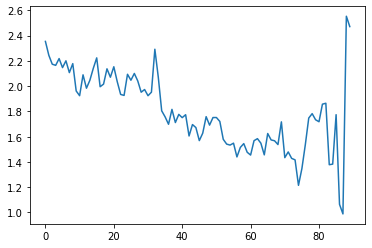

In [93]:
run.recorder.plot_loss()

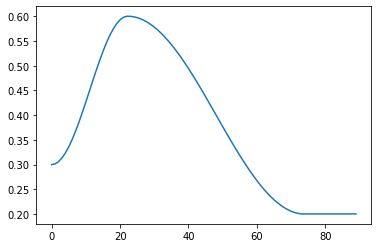

In [94]:
run.recorder.plot_lr()

** weight decay**

In [95]:
#export
def weight_decay(p, lr, wd, **kwargs):
  p.data.mul_(1 - lr*wd)
  return p

weight_decay._defaults = dict(wd=0.)

In [96]:
#export
def l2_reg(p, lr, wd, **kwargs):
  p.grad.data.add_(wd, p.data)
  return p
l2_reg._defaults = dict(wd=0.)

In [97]:
#export
def maybe_update(os, dest, f):
  for o in os:
    for k,v in f(o).items():
      if k not in dest: dest[k] = v

def get_defaults(d): return getattr(d, "_defaults", {})

In [98]:
class Optimizer():
  def __init__(self, params, steppers, **defaults):
    self.steppers = listify(steppers)
    maybe_update(self.steppers, defaults, get_defaults)
    self.param_groups = list(params)
    if not isinstance(self.param_groups[0], list): self.param_groups = [self.param_groups]
    self.hypers = [{**defaults} for p in self.param_groups]
    #self.steppers = listify(steppers)

  def grad_params(self):
    return [(p,hyper) for pg,hyper in zip(self.param_groups, self.hypers)
            for p in pg if p.grad is not None]

  def zero_grad(self):
    for p,hyper in self.grad_params():
      p.grad.detach_()
      p.grad.zero_()

  def step(self):
    for p,hyper  in self.grad_params(): compose(p, self.steppers, **hyper)


In [99]:
#export
sgd_opt = partial(Optimizer, steppers=[weight_decay, sgd_step])

In [100]:
learn, run = get_learn_run(nfs, data,0.4, conv_layer, cbs=cbfs, opt_func=sgd_opt)

3
16
16
3


In [101]:
model = learn.model

In [102]:
opt = sgd_opt(model.parameters(), lr=0.1)
test_eq(opt.hypers[0]['wd'], 0.)
test_eq(opt.hypers[0]["lr"], 0.1)

In [103]:
opt = sgd_opt(model.parameters(), lr=0.1, wd=1e-4)
test_eq(opt.hypers[0]['wd'], 1e-4)
test_eq(opt.hypers[0]["lr"], 0.1)

In [104]:
cbfs = [partial(AvgStatsCallback, accuracy), CudaCallback]

In [105]:
lean , run = get_learn_run(nfs, data, 0.3, conv_layer, cbs=cbfs, opt_func= partial(sgd_opt, wd=0.01))

3
16
16
3


In [106]:
run.fit(1, learn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train: [1.7818852967578414, tensor(0.3845, device='cuda:0')]
valid: [1.7266934962181528, tensor(0.4168, device='cuda:0')]


** adding momentum **

In [107]:
#export
class StatefulOptimizer(Optimizer):
  def __init__(self, params, steppers, stats=None, **defaults):
    self.stats = listify(stats)
    maybe_update(self.stats, defaults, get_defaults)
    super().__init__(params, steppers, **defaults)
    self.state = {}

  def step(self):
    for p, hyper in self.grad_params():
      if p not in self.state:
        self.state[p] = {}
        maybe_update(self.stats, self.state[p], lambda o: o.init_state(p))
      state = self.state[p]
      for stat in self.stats: state = stat.update(p, state, **hyper)
      compose(p, self.steppers, **state, **hyper)
      self.state[p] = state

In [108]:
#export
class Stat():
  _defaults = {}
  def init_state(self, p): raise NotImplementedError
  def update(self, p, state, **kwargs): raise NotImplementedError

In [109]:
class AverageGrad(Stat):
  _default = dict(mom=0.9)

  def init_state(self, p): return {'grad_avg': torch.zeros_like(p.grad.data)}
  def update(self, p , state, mom, **kwargs):
    state['grad_avg'].mul_(mom).add_(p.grad.data)
    return state

In [110]:
#export
def momentum_step(p , lr, grad_avg, **kwargs):
  p.data.add_(-lr, grad_avg)
  return p

In [111]:
sgd_mom_opt = partial(StatefulOptimizer, steppers=[momentum_step, weight_decay],
                      stats=AverageGrad(), wd = 0.01)


In [112]:
learn, run = get_learn_run(nfs, data, 0.3, conv_layer, cbs=cbfs, opt_func=sgd_mom_opt)

3
16
16
3


In [113]:
#run.fit(1, learn)

In [114]:
 x = torch.linspace(-4,4,200)
 y = torch.randn(200) + 0.3

 betas = [0.5, 0.7, 0.9, 0.99]

In [115]:
def plot_mom(f):
  _, axs = plt.subplots(2,2,figsize=(12,8))
  for beta, ax in zip(betas, axs.flatten()):
    ax.plot(y, linestyle="None", marker='.')
    avg, res = None,[]
    for i,yi in enumerate(y):
      avg,p =f(avg, beta, yi, i)
      res.append(p)
    ax.plot(res, color='red')
    ax.set_title(f'beta={beta}')

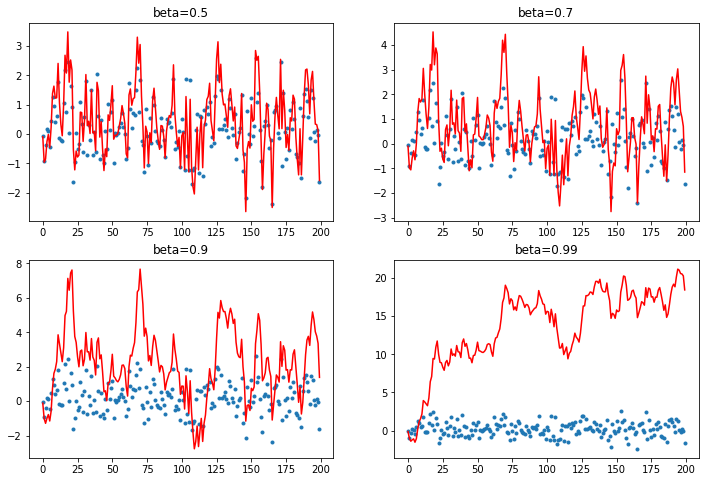

In [116]:
def mom1(avg, beta, yi, i):
  if avg is None: avg=yi
  res = beta*avg + yi
  return res,res
plot_mom(mom1)

In [117]:
def ewma(v1, v2, beta): return beta*v1 + (1- beta)*v2

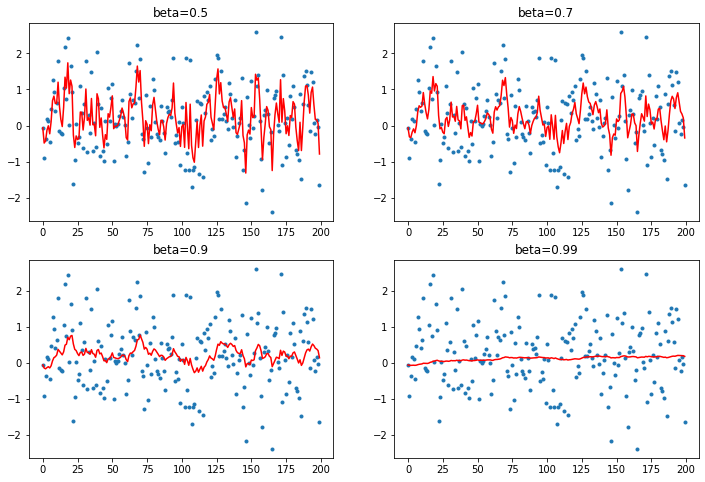

In [118]:
def mom2(avg,beta,yi,i):
  if avg is None: avg=yi
  avg = ewma(avg, yi, beta)
  return avg, avg
plot_mom(mom2)

In [119]:
y = 1 -(x/3)**2 + torch.randn(200)*0.1

In [120]:
y[0] = 0.5

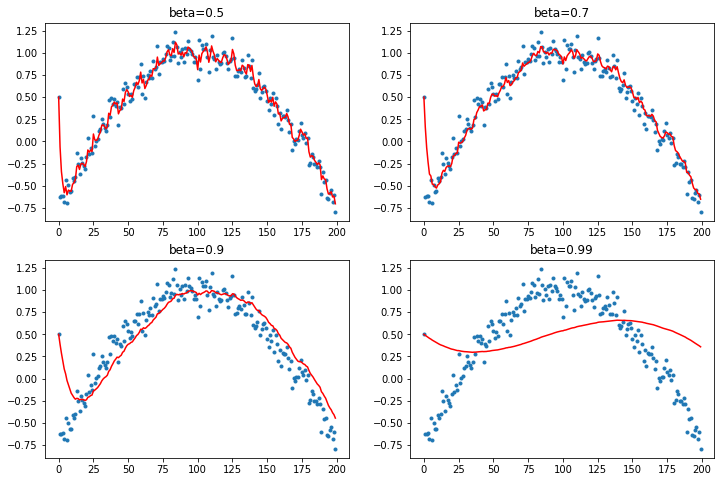

In [121]:
plot_mom(mom2)

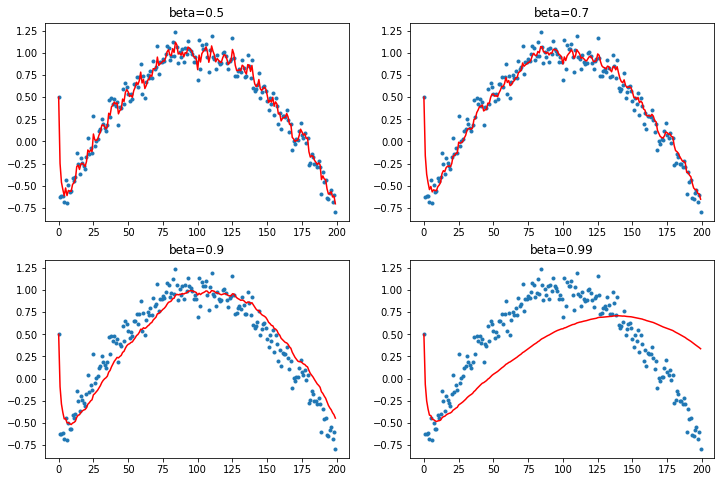

In [122]:
def mom3(avg, beta, yi, i):
  if avg is None: avg = 0
  avg = ewma(avg, yi, beta)
  return avg, avg/(1-beta**(i+1))

plot_mom(mom3)

In [123]:
#export
class AverageGrad(Stat):
  _defaults = dict(mom=0.9)
  def __init__(self, dampening:bool=False): self.dampening = dampening
  def init_state(self, p): return {"grad_avg": torch.zeros_like(p.grad.data)}
  def update(self, p, state, mom, **kwargs):
    state["mom_damp"] = 1-mom if self.dampening else 1.
    state['grad_avg'].mul_(mom).add_(state['mom_damp'], p.grad.data)
    return state

In [124]:
#export
class AverageSqrGrad(Stat):
  _defaults = dict(sqr_mom=0.99)
  def __init__(self, dampening:bool=False): self.dampening = dampening
  def init_state(self, p): return {"sqr_avg": torch.zeros_like(p.grad.data)}
  def update(self, p, state, sqr_mom, **kwargs):
    state["sqr_damp"] = 1-sqr_mom if self.dampening else 1.
    state['sqr_avg'].mul_(sqr_mom).addcmul_(state['sqr_damp'], p.grad.data,p.grad.data)
    return state

In [125]:
#export
class StepCount(Stat):
  def init_state(self, p): return {'step':0}
  def update(self, p, state, **kwargs):
    state['step'] += 1
    return state

In [126]:
#export 
def debias(mom,damp,step): return damp * (1 -mom**step) / (1-mom)

In [127]:
def adam_step(p, lr, mom, mom_damp, step, sqr_mom,sqr_damp, grad_avg, sqr_avg, eps, **kwargs):
  debias1 = debias(mom,     mom_damp, step)
  debias2 = debias(sqr_mom, sqr_damp, step)
  p.data.addcdiv_(-lr/debias1, grad_avg, (sqr_avg/debias2 + eps).sqrt())
  return p

adam_step._defaults = dict(eps=1e-5)

In [128]:
#export
adam_opt = partial(StatefulOptimizer, steppers=adam_step, stats=[AverageGrad(dampening=True), 
                                                                 AverageSqrGrad(), StepCount()])

In [129]:
learn, run = get_learn_run(nfs, data, 0.001, conv_layer, cbs=cbfs, opt_func=adam_opt)

3
16
16
3


In [130]:
run.fit(3, learn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train: [1.800705756943711, tensor(0.3783, device='cuda:0')]
valid: [1.5160666301751593, tensor(0.4968, device='cuda:0')]
train: [1.800705756943711, tensor(0.3783, device='cuda:0')]
valid: [1.445264684017553, tensor(0.5231, device='cuda:0')]
train: [1.800705756943711, tensor(0.3783, device='cuda:0')]
valid: [1.4362164433627453, tensor(0.5264, device='cuda:0')]


** LAMB **

In [131]:
def lamb_step(p, lr, mom, mom_damp, step, sqr_mom, sqr_damp, grad_avg, sqr_avg, eps, wd, **kwargs):
  debias1 = debias(mom, mom_damp, step)
  debias2 = debias(sqr_mom, sqr_damp, step)
  r1 = p.data.pow(2).mean().sqrt()
  step = (grad_avg/debias1) / ((sqr_avg/debias2).sqrt() + eps) + wd*p.data
  r2 = step.pow(2).mean().sqrt()
  p.data.add_(-lr * min(r1/r2,10), step)
  return p

lamb_step._defaults = dict(eps=1e-6, wd=0.)

In [132]:
lamb = partial(StatefulOptimizer, steppers=lamb_step, stats=[AverageGrad(dampening=True), AverageSqrGrad(), StepCount()])

In [133]:
learn , run = get_learn_run(nfs, data, 0.003, conv_layer, cbs=cbfs, opt_func=lamb)

3
16
16
3


In [134]:
run.fit(3, learn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train: [1.8468817242449045, tensor(0.3559, device='cuda:0')]
valid: [1.70884666102707, tensor(0.4224, device='cuda:0')]
train: [1.8468817242449045, tensor(0.3559, device='cuda:0')]
valid: [1.6534079939300768, tensor(0.4414, device='cuda:0')]
train: [1.8468817242449045, tensor(0.3559, device='cuda:0')]
valid: [1.646323040121447, tensor(0.4438, device='cuda:0')]


In [136]:
!pip install fire

     |████████████████████████████████| 92kB 8.0MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115928 sha256=076075d6f51c6c4287e099e3dae08657694a4b0e51f9d366067956d5569b99d2
  Stored in directory: /root/.cache/pip/wheels/af/19/30/1ea0cad502dcb4e66ed5a690279628c827aea38bbbab75d5ed
Successfully built fire


In [137]:
!python notebook2script.py 09_optimizers.ipynb

Converted 09_optimizers.ipynb to exp/nb_09.py


In [138]:
print("####### DONE #######")

####### DONE #######


**left lesson 11 at 1.40.23**
